# Calcul du rang effectiffe et géométrie

In [43]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "ExplanationPairSentencesTasks":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")

# import the different modules
## datasets
from src.data_module.hatexplain import HateXPlainDM
from src.data_module.yelp_hat import CLSTokenYelpHatDM, CLSTokenYelpHat50DM, CLSTokenYelpHat100DM, CLSTokenYelpHat200DM

# models
from pur_attention import AttitModel

# tools
from notebooks.attention_based.utils.ckp_config import *

# external librairies
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f">> device : {DEVICE}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> current directory : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks
>> cache path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache
>> model path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\models
>> dataset path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\dataset
>> logs path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\logs
>> device : cuda


## Avec l'optimisateur Adadelta

## HatexPlain

In [4]:
%%capture
# the hatexplain dataset : load all the dataset
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=-1)

dm = HateXPlainDM(**dm_kwargs)
dm.prepare_data()
# erank on the raw part
def erank_calculus(s : torch.tensor):
    sum_s = s.sum()
    return torch.exp(-((s /sum_s) * torch.log(s/sum_s)).sum())

erank_train = []
erank_raw = []

for l in range(6):
    model_args = dict(
            cache_path=model_path,
            mode="exp",
            vocab=dm.vocab,
            lambda_entrop=0,
            lambda_supervise=0,
            lambda_lagrange=0,
            pretrained_vectors="glove.840B.300d",
            num_layers=l+1,
            num_heads=1,
            d_embedding=300,
            data="hatexplain",
            num_class=dm.num_class,
            opt="adadelta"
        )
    # load the raw model
    raw_model = AttitModel(**model_args)
    raw_model = raw_model.eval()

    # load the trained model
    ckp = os.path.join(log_path, "PurAttentionAdadelta", f"run=0_hatexplain_l=0{l+1}_h=1_adadelta", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionAdadelta", f"run=0_hatexplain_l=0{l+1}_h=1_adadelta", "hparams.yaml")
    train_model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    train_model = train_model.eval()

    trained_vectors = train_model.model.embedding.state_dict()["weight"]
    raw_vectors = raw_model.model.embedding.state_dict()["weight"]


    S_raw = torch.linalg.svdvals(raw_vectors)
    S_train = torch.linalg.svdvals(trained_vectors)

    erank_train.append(erank_calculus(S_train))
    erank_raw.append(erank_calculus(S_raw))

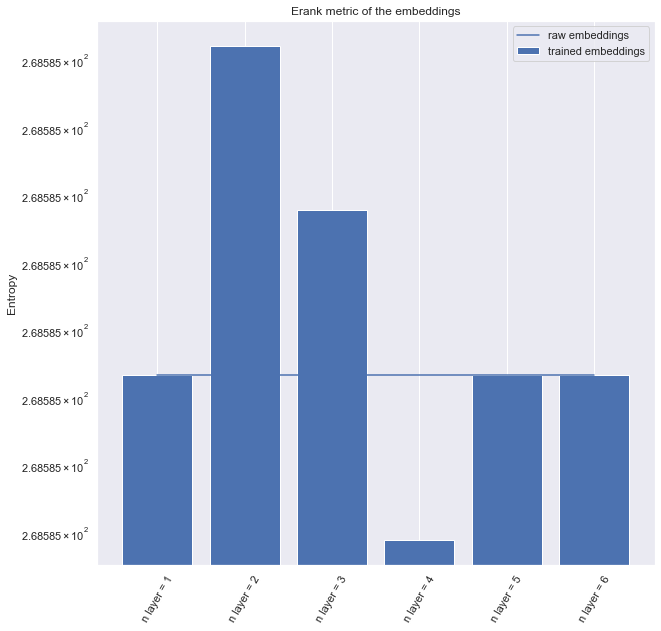

In [5]:
fig = plt.figure(figsize=(10,10))
txt = plt.title("Erank metric of the embeddings")
plt.bar(list(range(6)), erank_train, label="trained embeddings")
plt.plot(list(range(6)), erank_raw, label="raw embeddings")
plt.yscale("log")
plt.ylabel("Entropy")
plt.legend()
x = list(range(0, 6))
plt.xticks(x, [f"n layer = {l+1}" for l in x], rotation=60)
plt.savefig(os.path.join(os.getcwd(),".cache","fig","hatexplain_h=1_l=[1,10]", "erank_embeddings_adadelta_hatexplain.png"))

## YelpHat50

Nous avons ici des problèmes avec le dataset.

In [48]:
%%capture
# the yelphat dataset
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=128,
                 num_workers=0,
                 n_data=-1)
dm = CLSTokenYelpHat50DM(**dm_kwargs)
dm.prepare_data()

# erank on the raw part
def erank_calculus(s : torch.tensor):
    sum_s = s.sum()
    return torch.exp(-((s /sum_s) * torch.log(s/sum_s)).sum())

erank_train = []
erank_raw = []

for l in range(6):
    model_args = dict(
            cache_path=model_path,
            mode="exp",
            vocab=dm.vocab,
            lambda_entrop=0,
            lambda_supervise=0,
            lambda_lagrange=0,
            pretrained_vectors="glove.840B.300d",
            num_layers=l+1,
            num_heads=1,
            d_embedding=300,
            data="yelphat50",
            num_class=dm.num_class,
            opt="adadelta"
        )
    # load the raw model
    raw_model = AttitModel(**model_args)
    raw_model = raw_model.eval()

    # load the trained model
    ckp = os.path.join(log_path, "PurAttentionAdadelta", f"run=0_yelphat50_l=0{l+1}_h=1_adadelta", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionAdadelta", f"run=0_yelphat50_l=0{l+1}_h=1_adadelta", "hparams.yaml")
    train_model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    train_model = train_model.eval()

    trained_vectors = train_model.model.embedding.state_dict()["weight"]
    raw_vectors = raw_model.model.embedding.state_dict()["weight"]


    S_raw = torch.linalg.svdvals(raw_vectors)
    S_train = torch.linalg.svdvals(trained_vectors)

    erank_train.append(erank_calculus(S_train))
    erank_raw.append(erank_calculus(S_raw))

RuntimeError: Error(s) in loading state_dict for AttitModel:
	size mismatch for model.embedding.weight: copying a param with shape torch.Size([7313, 300]) from checkpoint, the shape in current model is torch.Size([7501, 300]).

In [ ]:
fig = plt.figure(figsize=(10,10))
txt = plt.title("Erank metric of the embeddings")
plt.bar(list(range(6)), erank_train, label="trained embeddings")
plt.plot(list(range(6)), erank_raw, label="raw embeddings")
plt.yscale("log")
plt.ylabel("Entropy")
plt.legend()
x = list(range(0, 6))
plt.xticks(x, [f"n layer = {l+1}" for l in x], rotation=60)
plt.savefig(os.path.join(os.getcwd(),".cache","fig","hatexplain_h=1_l=[1,10]", "erank_embeddings_adadelta_yelphat.png"))

## Avec l'optimisateur Adam

In [6]:
%%capture
# erank on the raw part
def erank_calculus(s : torch.tensor):
    sum_s = s.sum()
    return torch.exp(-((s /sum_s) * torch.log(s/sum_s)).sum())

erank_train = []
erank_raw = []

for l in range(6):
    model_args = dict(
            cache_path=model_path,
            mode="exp",
            vocab=dm.vocab,
            lambda_entrop=0,
            lambda_supervise=0,
            lambda_lagrange=0,
            pretrained_vectors="glove.840B.300d",
            num_layers=l+1,
            num_heads=1,
            d_embedding=300,
            data="hatexplain",
            num_class=dm.num_class,
            opt="adadelta"
        )
    # load the raw model
    raw_model = AttitModel(**model_args)
    raw_model = raw_model.eval()

    # load the trained model
    ckp = os.path.join(log_path, "PurAttentionAdam", f"run=0_hatexplain_l=0{l+1}_h=1_adam", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionAdam", f"run=0_hatexplain_l=0{l+1}_h=1_adam", "hparams.yaml")
    train_model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    train_model = train_model.eval()

    trained_vectors = train_model.model.embedding.state_dict()["weight"]
    raw_vectors = raw_model.model.embedding.state_dict()["weight"]


    S_raw = torch.linalg.svdvals(raw_vectors)
    S_train = torch.linalg.svdvals(trained_vectors)

    erank_train.append(erank_calculus(S_train))
    erank_raw.append(erank_calculus(S_raw))

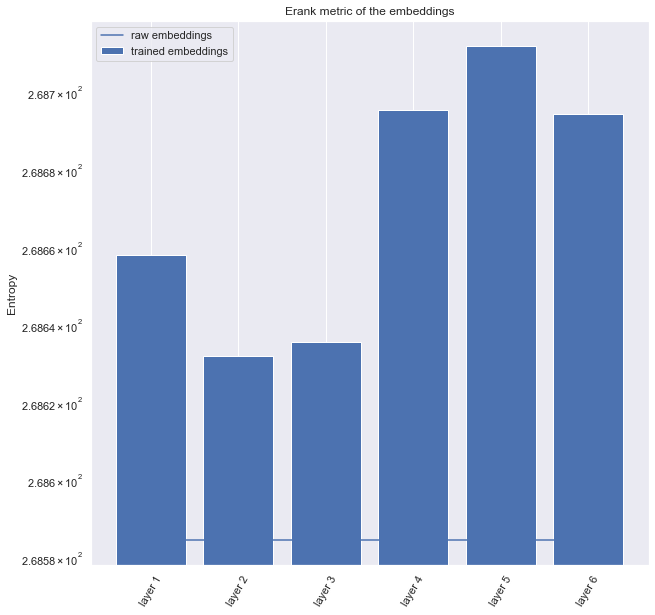

In [7]:
fig = plt.figure(figsize=(10,10))
txt = plt.title("Erank metric of the embeddings")
plt.bar(list(range(6)), erank_train, label="trained embeddings")
plt.plot(list(range(6)), erank_raw, label="raw embeddings")
plt.yscale("log")
plt.ylabel("Entropy")
#plt.xlabel("Layer")
plt.legend()
x = list(range(0, 6))
plt.xticks(x, [f"layer {l+1}" for l in x], rotation=60)
plt.savefig(os.path.join(os.getcwd(),".cache","fig","hatexplain_h=1_l=[1,10]", "erank_embeddings_adam.png"))